## Using Time Series Analysis to forescasting sales


Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values.



In [1]:
#install 
# pip install plotly==5.4.0
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.express as px
import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA

#pip install progressbar
from progressbar import *

from sklearn.preprocessing import LabelEncoder

from math import sqrt

import plotly.graph_objects as go
import plotly.express as px
import plotly as py

pd.set_option('display.max_rows',50)
pd.set_option('display.max_columns',150)
import matplotlib.pyplot as plt

#pip install datetime
from datetime import datetime as dt


#graph design
#pip install dash
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

C:\Users\MELODY~1\AppData\Local\Temp/ipykernel_16120/2807057372.py:40: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

C:\Users\MELODY~1\AppData\Local\Temp/ipykernel_16120/2807057372.py:41: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

There are several categories in the Iowa Liquor Retail Sales, we start from time series analysis and forecasting for whiskies (category_group = 101) sales.

In [4]:
# 2017 18 19 --> Training dataset
from pandas.io import gbq
df_train = gbq.read_gbq('SELECT  *,extract(year from date) as year,left(category,3) as category_group FROM bigquery-public-data.iowa_liquor_sales.sales where extract(year from date) > 2016 and extract(year from date) < 2020 and left(category,3) = "101"', project_id='iowa-liquor-retail-sale', reauth='true')
df_train.shape
lossDict = {}
lossDict['fullsize'] = df_train.shape[0] 

df_train.isnull().sum() #Find the number of null per each columns
df_train.dropna(inplace=True)
lossDict['nullloss'] = (lossDict['fullsize']- df_train.shape[0])
df_train.isnull().sum() #Double check whether there is null records
#We should be able to drop NULL, and loss 50K
#This loss is acceptable.
rowsum = lossDict['nullloss'] 
print("Rows Lost: " + str(rowsum) + "\n Percentage Loss: " + str(rowsum/lossDict['fullsize']))
# Printing minimum and the maximum date from dataset.
print(df_train['date'].min())
print(df_train['date'].max())
# df_traing['category_group'] = df_traing['category'].str[:3]

#Convert country name to uppercase
df_train['county'] = df_train['county'].apply(lambda x: x.upper())

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=jV3qigGdYunFWd5NCRpdQNqWRXpNUI&prompt=consent&access_type=offline
Enter the authorization code: 4/1AX4XfWjRq1rDFYuiVdLYYsOdXs74dPsyJGy9VsuyQFUeT1RAS7t14nkytJc
Rows Lost: 194862
 Percentage Loss: 0.10027417392754151
2017-01-03 00:00:00
2019-12-31 00:00:00


In [5]:
df_train = df_train.groupby('date')['sale_dollars'].sum().reset_index()

In [6]:
df_train = df_train.set_index('date')
df_train.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-16',
               ...
               '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-23',
               '2019-12-24', '2019-12-26', '2019-12-27', '2019-12-28',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='date', length=774, freq=None)

In [7]:
y = df_train['sale_dollars'].resample('MS').mean()

In [8]:
y['2017':]

date
2017-01-01    265962.713333
2017-02-01    358135.886500
2017-03-01    299721.056087
2017-04-01    301998.013500
2017-05-01    335801.268696
2017-06-01    322978.585909
2017-07-01    304612.410952
2017-08-01    304222.703913
2017-09-01    349987.174000
2017-10-01    424656.280000
2017-11-01    385678.021500
2017-12-01    510311.390500
2018-01-01    291144.288636
2018-02-01    358229.874500
2018-03-01    327058.900000
2018-04-01    346634.465238
2018-05-01    379640.730000
2018-06-01    371347.918571
2018-07-01    320988.810476
2018-08-01    357990.365652
2018-09-01    349972.011053
2018-10-01    492061.794348
2018-11-01    417981.218000
2018-12-01    545418.299524
2019-01-01    307414.173810
2019-02-01    397198.456000
2019-03-01    338828.644286
2019-04-01    338877.310000
2019-05-01    394908.826522
2019-06-01    362054.171818
2019-07-01    384710.653913
2019-08-01    344326.197727
2019-09-01    406029.900476
2019-10-01    466364.399565
2019-11-01    387303.324583
2019-12-01    5

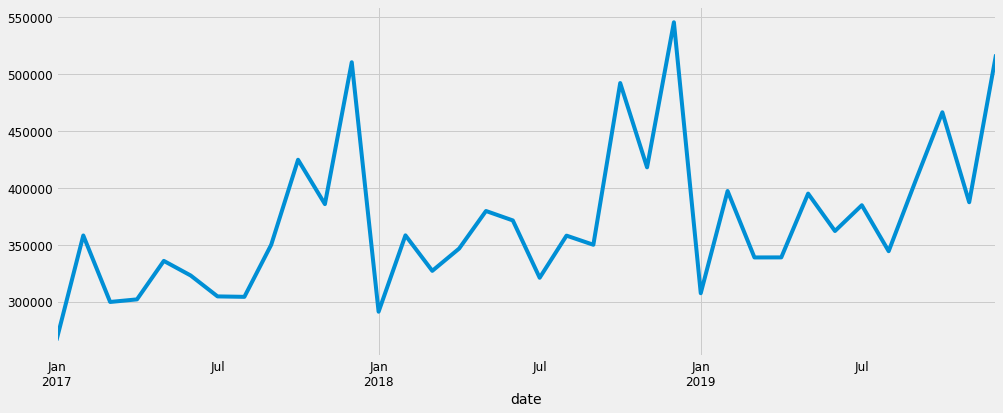

In [9]:
y.plot(figsize=(15, 6))
plt.show()

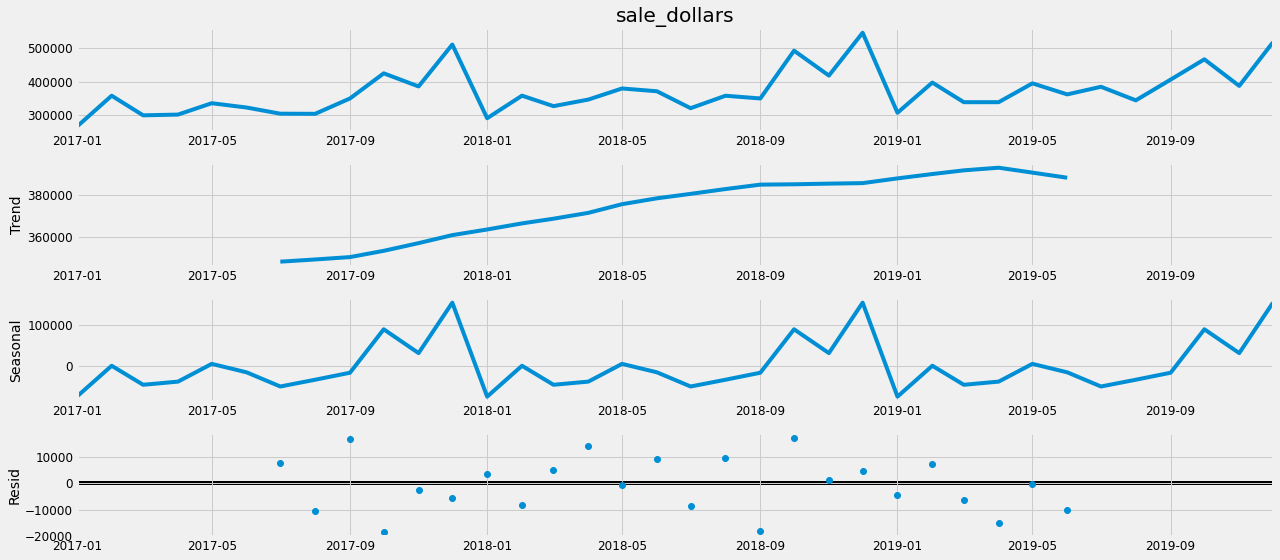

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [11]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [35]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal
                                            ,enforce_stationarity=False
                                            ,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue 

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1000.6511590578815
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:842.3991336847745
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:550.7295973872577
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:264.28604095290655
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:567.7438473078548
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:562.143701236713
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:286.37569268526926
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:260.6458468771042
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:954.6292243058059
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:616.0029908265889
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:527.3281143686901
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:241.93848426835996
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:667.5629243325625
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:614.3977286155243
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:288.540286567174
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:240.66537797247605
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:868.9254626637638
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:552.2144719800064
ARIMA(0

In [36]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
#                                 enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8347      0.144     -5.780      0.000      -1.118      -0.552
ma.L1          0.7901      0.150      5.283      0.000       0.497       1.083
ar.S.L12      -0.0424      0.047     -0.897      0.370      -0.135       0.050
sigma2       7.45e+08   9.55e-11    7.8e+18      0.000    7.45e+08    7.45e+08


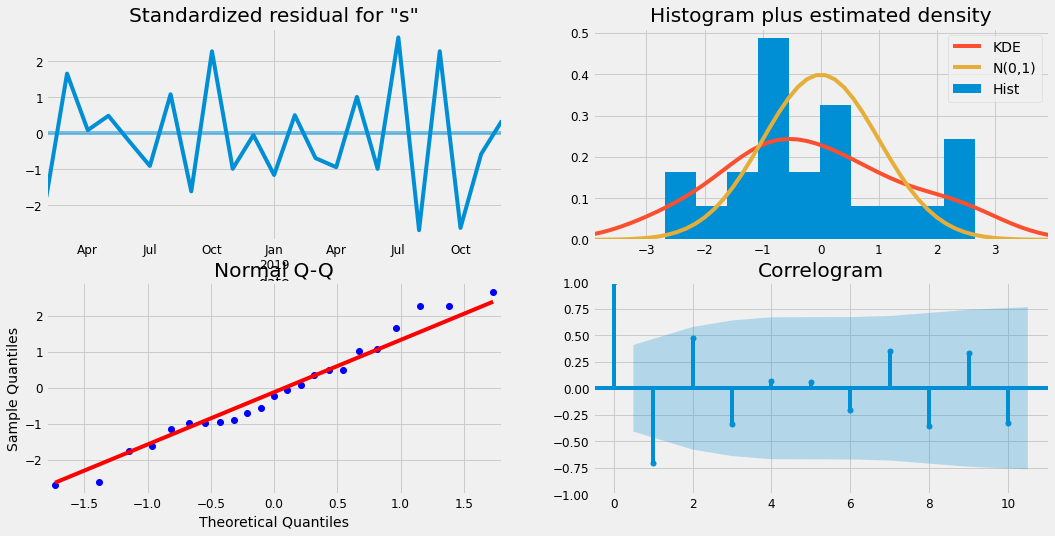

In [37]:
results.plot_diagnostics(figsize = (16,8))
plt.show()

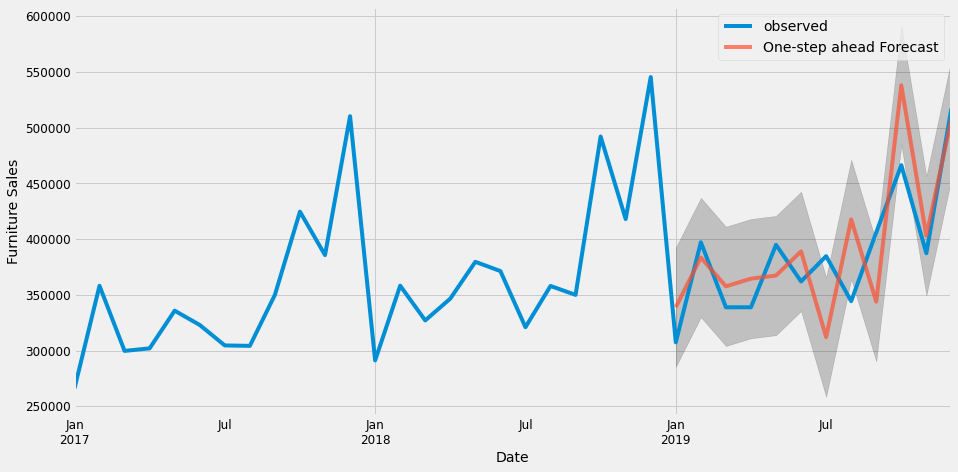

In [39]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [40]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1973664429.16


In [41]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 44425.94


## Producing and visualizing forecasts

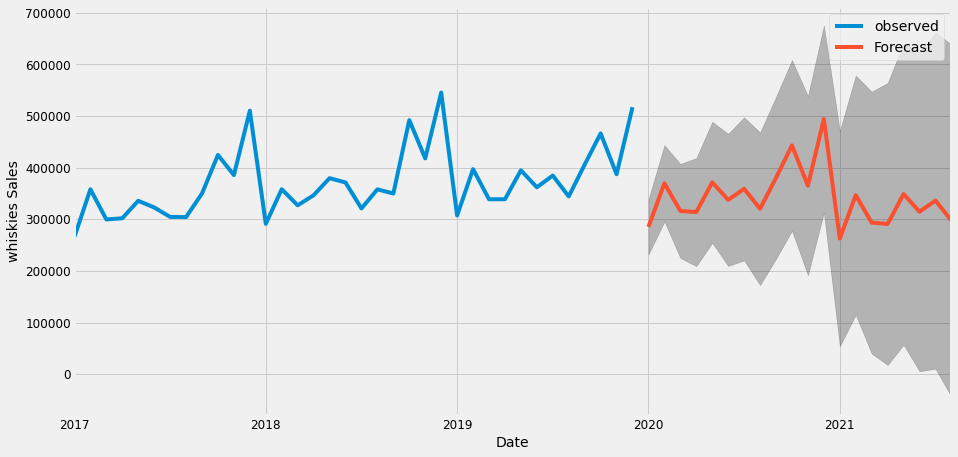

In [45]:
pred_uc = results.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('whiskies Sales')
plt.legend()
plt.show()